In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/Project

/content/gdrive/My Drive/Project


In [3]:
! git clone https://github.com/Microsoft/Recommenders

fatal: destination path 'Recommenders' already exists and is not an empty directory.


In [4]:
pip install papermill

     |████████████████████████████████| 1.1MB 10.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 112kB 22.5MB/s 
     |████████████████████████████████| 727kB 18.9MB/s 
     |████████████████████████████████| 747kB 30.1MB/s 
  Created wheel for black: filename=black-20.8b1-cp36-none-any.whl size=124186 sha256=4fe1f2d6704bec7143f404b0d65acc3dd7fe5a3a3a7ed12c213e5567a4435a62
  Stored in directory: /root/.cache/pip/wheels/6e/10/b5/edf7359c2edd0305cce7e3f96e07daf7ce55dceac9d3ce3373
Successfully built black
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


In [5]:
import os
os.chdir('/content/gdrive/My Drive/Project/Recommenders')

In [6]:
import sys
sys.path.append("../../")
import time
import os
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
import papermill as pm
import torch, fastai
from fastai.collab import EmbeddingDotBias, collab_learner, CollabDataBunch, load_learner

from reco_utils.dataset import movielens
from reco_utils.dataset.python_splitters import python_stratified_split
from reco_utils.recommender.fastai.fastai_utils import cartesian_product, score
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from reco_utils.evaluation.python_evaluation import rmse, mae, rsquared, exp_var

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Fast AI version: {}".format(fastai.__version__))
print("Torch version: {}".format(torch.__version__))
print("Cuda Available: {}".format(torch.cuda.is_available()))
print("CuDNN Enabled: {}".format(torch.backends.cudnn.enabled))

System version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
Pandas version: 1.1.4
Fast AI version: 1.0.61
Torch version: 1.7.0+cu101
Cuda Available: True
CuDNN Enabled: True


In [7]:
df = pd.read_csv('Dataset.csv',sep=',')

In [8]:
df.head(5)

,SnackId,UserId,UserName,Score,Time
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600


In [9]:
uni_snacks=df.groupby(['SnackId']).count().reset_index()[df.groupby(['SnackId']).count().reset_index()['UserId']>=80]

In [10]:
snack_id = []
for i in uni_snacks['SnackId']:
  if(len(snack_id)==30):
    break
  else:
    if(i not in snack_id):
      snack_id.append(i)


In [11]:
df=df[df['SnackId'].isin(snack_id)]

In [12]:
from google.colab import files
df.to_csv('snacks.csv')

In [13]:
df_fastai=df[['UserId','SnackId','Score','Time']]

In [14]:
USER, ITEM, RATING, TIMESTAMP, PREDICTION = 'UserId', 'SnackId', 'Score', 'Time', 'Prediction'

In [15]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
SNACKS_DATA_SIZE = '100k'

# Model parameters
N_FACTORS = 40
EPOCHS = 5

In [16]:
# Split the dataset
train_valid_df, test_df = python_stratified_split(
    df_fastai, 
    ratio=0.75, 
    min_rating=1, 
    filter_by="user", 
    col_user=USER, 
    col_item=ITEM
)

In [17]:
test_df.to_csv('test_df.csv')
train_valid_df.to_csv('train_valid_df.csv')


In [18]:
##Training

In [19]:
# fix random seeds to make sure our runs are reproducible
np.random.seed(101)
torch.manual_seed(101)
torch.cuda.manual_seed_all(101)

In [20]:
start_time = time.time()

data = CollabDataBunch.from_df(train_valid_df, user_name=USER, item_name=ITEM, rating_name=RATING, valid_pct=0)

preprocess_time = time.time() - start_time

In [21]:
data.show_batch()

UserId,SnackId,target
A1Y09QLADQYQJG,B00004RYGX,5.0
A3TNR97O3KP4Q7,B00004CI84,5.0
AX1LTHFK5VYJM,B00027CL5S,5.0
A8891HVRDJAM6,B000084E6V,5.0
A8CZNLAX7VB49,B00008JOL0,3.0


In [22]:
learn = collab_learner(data, n_factors=N_FACTORS, y_range=[0,5.5], wd=1e-1)
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(2517, 40)
  (i_weight): Embedding(31, 40)
  (u_bias): Embedding(2517, 1)
  (i_bias): Embedding(31, 1)
)

In [23]:
start_time = time.time()

learn.fit_one_cycle(EPOCHS, max_lr=5e-3)

train_time = time.time() - start_time + preprocess_time
print("Took {} seconds for training.".format(train_time))

epoch,train_loss,valid_loss,time
0,3.810665,#na#,00:00
1,2.522579,#na#,00:00
2,0.997030,#na#,00:00
3,0.337361,#na#,00:00
4,0.125380,#na#,00:00


Took 2.890979766845703 seconds for training.


In [24]:
learn.export('snacks_model.pkl')

In [25]:
learner = load_learner(path=".", file = 'snacks_model.pkl')

In [26]:
total_users, total_items = learner.data.train_ds.x.classes.values()
total_items = total_items[1:]
total_users = total_users[1:]

In [27]:
print(total_users,total_items)
print(len(total_items))
print(len(total_users))

['A100SV0E9A3EM4' 'A100WO06OQR8BQ' 'A101P2KHWCU0G6' 'A101YL8D6BZET8' ... 'AZU4M5K1N2LAB' 'AZWRC1QS9JW0X'
 'AZX3LW4HHPNCV' 'AZZTH6DJ0KSIP'] ['7310172001' '7310172101' 'B00004CI84' 'B00004CXX9' 'B00004RAMY' 'B00004RBDU' 'B00004RYGX' 'B000084DWM' 'B000084E6V'
 'B000084ETV' 'B000084EZ4' 'B00008CQVA' 'B00008JOL0' 'B0000DGG1U' 'B0000V8IOE' 'B00012182G' 'B00014DXCC' 'B00014IVPQ'
 'B00014JYNO' 'B0001ES9F8' 'B0001ES9FI' 'B00020HHAO' 'B00020HHE0' 'B00020HHGS' 'B00020HHHC' 'B00020HHK4' 'B00020HHM2'
 'B00020HHRW' 'B000255OIG' 'B00027CL5S']
30
2516


In [28]:
test_users = test_df[USER].unique()
test_users = np.intersect1d(test_users, total_users)
print(len(test_users))

531


In [29]:
users_items = cartesian_product(np.array(test_users),np.array(total_items))
users_items = pd.DataFrame(users_items, columns=[USER,ITEM])

In [30]:
users_items.shape

(15930, 2)

In [31]:
training_removed = pd.merge(users_items, train_valid_df.astype(str), on=[USER, ITEM], how='left')
training_removed = training_removed[training_removed[RATING].isna()][[USER, ITEM]]

In [32]:
training_removed

,UserId,SnackId
0,A1033RWNZWEMR5,7310172001
1,A1033RWNZWEMR5,7310172101
3,A1033RWNZWEMR5,B00004CXX9
4,A1033RWNZWEMR5,B00004RAMY
5,A1033RWNZWEMR5,B00004RBDU
...,...,...
15977,AZU4M5K1N2LAB,B0001ES9FI
15980,AZU4M5K1N2LAB,B00020HHGS
15981,AZU4M5K1N2LAB,B00020HHHC
15985,AZU4M5K1N2LAB,B000255OIG


In [33]:
start_time = time.time()

top_k_scores = score(learner, 
                     test_df=training_removed,
                     user_col=USER, 
                     item_col=ITEM, 
                     prediction_col=PREDICTION)

test_time = time.time() - start_time
print("Took {} seconds for {} predictions.".format(test_time, len(training_removed)))

Took 0.03360581398010254 seconds for 14181 predictions.


In [34]:
top_k_scores.head(10)

,UserId,SnackId,Prediction
17,A1033RWNZWEMR5,B00014IVPQ,3.948084
4,A1033RWNZWEMR5,B00004RAMY,3.791441
8,A1033RWNZWEMR5,B000084E6V,3.608277
11,A1033RWNZWEMR5,B00008CQVA,3.555043
10,A1033RWNZWEMR5,B000084EZ4,3.502705
19,A1033RWNZWEMR5,B0001ES9F8,3.483903
15,A1033RWNZWEMR5,B00012182G,3.468963
13,A1033RWNZWEMR5,B0000DGG1U,3.354697
3,A1033RWNZWEMR5,B00004CXX9,3.320167
14,A1033RWNZWEMR5,B0000V8IOE,3.263464


In [35]:
from google.colab import files
top_k_scores.to_csv('top_k_scores.csv')

In [36]:
eval_map = map_at_k(test_df, top_k_scores, col_user=USER, col_item=ITEM, 
                    col_rating=RATING, col_prediction=PREDICTION, 
                    relevancy_method="top_k", k=TOP_K)

In [37]:
eval_ndcg = ndcg_at_k(test_df, top_k_scores, col_user=USER, col_item=ITEM, 
                      col_rating=RATING, col_prediction=PREDICTION, 
                      relevancy_method="top_k", k=TOP_K)

In [38]:
eval_precision = precision_at_k(test_df, top_k_scores, col_user=USER, col_item=ITEM, 
                                col_rating=RATING, col_prediction=PREDICTION, 
                                relevancy_method="top_k", k=TOP_K)

In [39]:

eval_recall = recall_at_k(test_df, top_k_scores, col_user=USER, col_item=ITEM, 
                          col_rating=RATING, col_prediction=PREDICTION, 
                          relevancy_method="top_k", k=TOP_K)

In [40]:
print("Model:\t" + learn.__class__.__name__,
      "Top K:\t%d" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

Model:	CollabLearner
Top K:	10
MAP:	0.234045
NDCG:	0.367592
Precision@K:	0.103766
Recall@K:	0.782486


In [42]:
type(eval_map)

numpy.float64

In [43]:
start_time = time.time()
scores = score(learner, 
               test_df=test_df.copy(), 
               user_col=USER, 
               item_col=ITEM, 
               prediction_col=PREDICTION)
test_time = time.time() - start_time
print("Took {} seconds for {} predictions.".format(test_time, len(test_df.copy())))

Took 0.013020515441894531 seconds for 716 predictions.


In [44]:
scores.to_csv('scores.csv')

In [45]:
scores

,UserId,SnackId,Prediction
451799,A1033RWNZWEMR5,B00004CXX9,3.320167
451948,A1048CYU0OV4O8,B00004CXX9,3.364652
381401,A10G136JEISLVR,B00020HHK4,4.095248
212780,A10G136JEISLVR,B00020HHAO,4.067328
484455,A10G136JEISLVR,B00020HHGS,3.507183
...,...,...,...
217499,AZ7GJ72KEZTB9,7310172101,3.926309
451977,AZADBDIG2188H,B00004CXX9,3.428005
451859,AZRJH4JFB59VC,B00004CXX9,2.342683
484373,AZU4M5K1N2LAB,B00020HHGS,3.919205


In [46]:
eval_r2 = rsquared(test_df, scores, col_user=USER, col_item=ITEM, col_rating=RATING, col_prediction=PREDICTION)
eval_rmse = rmse(test_df, scores, col_user=USER, col_item=ITEM, col_rating=RATING, col_prediction=PREDICTION)
eval_mae = mae(test_df, scores, col_user=USER, col_item=ITEM, col_rating=RATING, col_prediction=PREDICTION)
eval_exp_var = exp_var(test_df, scores, col_user=USER, col_item=ITEM, col_rating=RATING, col_prediction=PREDICTION)

print("Model:\t" + learn.__class__.__name__,
      "RMSE:\t%f" % eval_rmse,
      "MAE:\t%f" % eval_mae,
      "Explained variance:\t%f" % eval_exp_var,
      "R squared:\t%f" % eval_r2, sep='\n')

Model:	CollabLearner
RMSE:	1.124229
MAE:	1.043473
Explained variance:	0.600886
R squared:	0.046055


In [47]:
pip install nteract-scrapbook

     |████████████████████████████████| 266kB 8.1MB/s 


In [48]:
import scrapbook as sc
sc.glue("map", eval_map)
sc.glue("ndcg", eval_ndcg)
sc.glue("precision", eval_precision)
sc.glue("recall", eval_recall)
sc.glue("rmse", eval_rmse)
sc.glue("mae", eval_mae)
sc.glue("exp_var", eval_exp_var)
sc.glue("rsquared", eval_r2)
sc.glue("train_time", train_time)
sc.glue("test_time", test_time)

In [49]:
print(eval_map,eval_rmse,eval_mae)

0.23404515290108507 1.124229251239978 1.0434732076921438


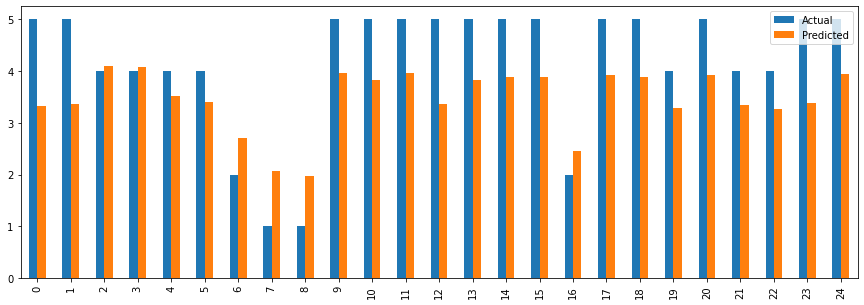

In [51]:
#import matplotlib
#import matplotlib.pyplot as plt

y_act=test_df['Score']
y_pred=scores['Prediction']

acc_test =np.array(y_act)

pred_test =np.array(y_pred)

df1 = pd.DataFrame({'Actual':acc_test.flatten(), 'Predicted': pred_test.flatten()})
df1

df2 = df1.head(n=25)

df2.plot(kind='bar',figsize=(15,5))

#plt.grid(which='major',linestyle='-',linewidth='0.5',color='green')
#plt.grid(which='minor',linestyle=':',linewidth='0.5',color='black')

plt.show()


#st.pyplot